# Word2Vec


---

1. Data Processing
2. CBOW W2V using gensim
3. Skip-gram W2V using gensim
4. numpy CBOW Word2Vec


## Representing word “meaning” with Word2Vec (W2V)
- The idea is simple: words that appear in similar context have similar meaning.
- It is based on the idea that words appearing in similar contexts have similar meanings.

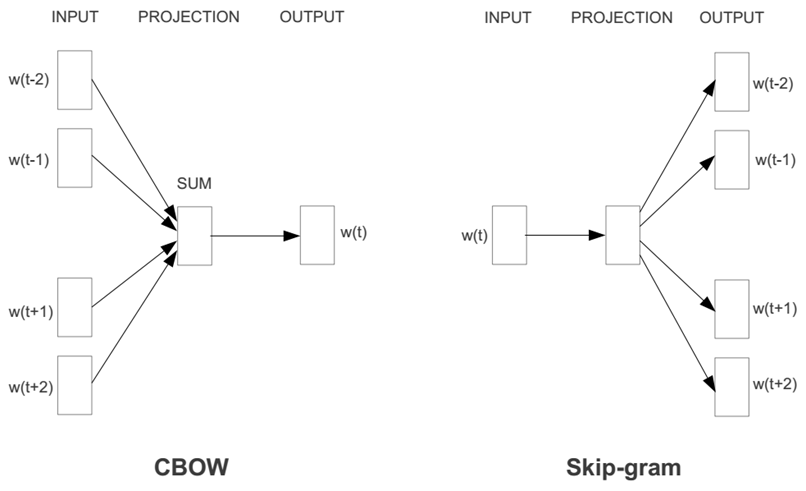

## 0. Environment Setup


In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
from math import log
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import re

### Practice Dataset - IMDb Movie Reviews


In [ ]:
import nltk
from nltk.corpus import movie_reviews
import pandas as pd

# Download and load the NLTK movie reviews dataset
nltk.download('movie_reviews')

docs = [movie_reviews.raw(fileid) for fileid in movie_reviews.fileids()]
data = pd.DataFrame({'document': docs})
data.head()

In [ ]:
# Check data samples
data = data.sample(n=100, random_state=42)

print("Data samples:")
print(data.head())

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

## 1. Data Preprocessing


In [ ]:
stop_words = set(stopwords.words('english'))

X = []
for doc in data['document']:
    tokens = word_tokenize(doc)
    tokens = [w.lower() for w in tokens if w.isalpha() and w.lower() not in stop_words]
    X.append(tokens)

In [ ]:
print("\nPreprocessed samples:")
print(X[:3])

## 2. CBOW (Continuous Bag-of-Words) W2V
- Predicts the center word from its surrounding context words.
- CBOW learns by asking: given the context (neighbor words), which word is missing?

**Example**

Sentence: “I went to the ___ and drank coffee.”

Input (context words): ["I", "went", "to", "the", "and", "drank", "coffee"]

Target (center word to predict): "cafe"

During training, the model updates the embedding vectors of the context words so it can better predict "cafe".


In [ ]:
from gensim.models import Word2Vec

# Train CBOW model
cbow_model = Word2Vec(
    sentences=X,
    vector_size=100,
    window=5,
    min_count=5,
    sg=0  # 0: CBOW, 1: Skip-gram
)

# 'movie'
similar_words_cbow_movie = cbow_model.wv.most_similar('movie')
print("Words similar to 'movie' (CBOW):")
print(similar_words_cbow_movie)

# 'fun'
similar_words_cbow_fun = cbow_model.wv.most_similar('fun')
print("\nWords similar to 'fun' (CBOW):")
print(similar_words_cbow_fun)

#### CBOW Result Visualization


In [ ]:
from sklearn.manifold import TSNE

# Select words and extract embeddings
words = ["movie", "film", "fun", "boring", "great", "bad"]
words += list(cbow_model.wv.key_to_index.keys())
word_vectors = np.array([cbow_model.wv[w] for w in words if w in cbow_model.wv])

# 2D projection using t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(word_vectors)

In [ ]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:-6, 0], embeddings_2d[:-6, 1])
plt.scatter(embeddings_2d[-6:, 0], embeddings_2d[-6:, 1], c='red')

## 3. Skip-gram W2V
- Predicts context words from a center word.
- Unlike CBOW, it looks at the center word and generates the related neighbors.

**Example**

Input (center word): "cafe"

Target (context words to predict): ["I", "went", "to", "the", "and", "drank", "coffee"]

Because Skip-gram must predict multiple context words from a single center word, it usually performs more computations than CBOW.
For instance, it learns the relation between "café" and "coffee" once, then "cafe" and "went" again, and so on for each context word.


In [ ]:
from gensim.models import Word2Vec

# Train Skip-gram model
skipgram_model = Word2Vec(
    sentences=X,
    vector_size=100,
    window=5,
    min_count=5,
    sg=1  # 0: CBOW, 1: Skip-gram
)

# 'movie'
similar_words_sg_movie = skipgram_model.wv.most_similar('movie')
print("Words similar to 'movie' (Skip-gram):")
print(similar_words_sg_movie)

# 'fun'
similar_words_sg_fun = skipgram_model.wv.most_similar('fun')
print("\nWords similar to 'fun' (Skip-gram):")
print(similar_words_sg_fun)

#### Skip-gram Result Visualization


In [ ]:
# Select words and extract embeddings
words = ["movie", "film", "fun", "boring", "great", "bad"]
words += list(skipgram_model.wv.key_to_index.keys())
words = [w for w in words if w in skipgram_model.wv]

word_vectors = np.array([skipgram_model.wv[w] for w in words])

# 2D projection using t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(word_vectors)

In [ ]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:-6, 0], embeddings_2d[:-6, 1])
plt.scatter(embeddings_2d[-6:, 0], embeddings_2d[-6:, 1], c='red')

**CBOW:** Averages multiple context words (sum/avg) to predict the center word → noise is smoothed out, producing a more averaged/soft meaning → embeddings cluster closer together.

**Skip-gram:** Uses the center word to predict each context word individually → preserves fine-grained differences between words (especially rare ones) → embeddings are more dispersed.

## 4. CBOW Word2Vec using numpy


In [ ]:
# corpus
corpus = X[:3]

In [ ]:
print(corpus)

In [ ]:
import numpy as np

## Make training dataset

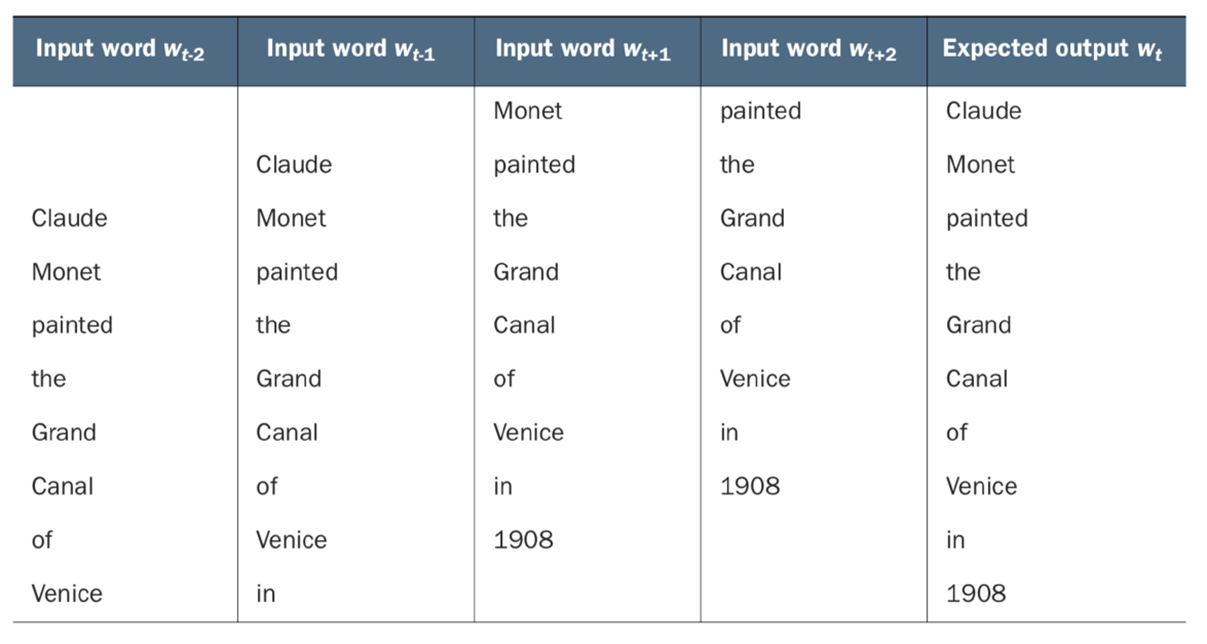

In [ ]:
def get_pair_data(tokenized_corpus, window_size=2):
    """Generate (context_words, target_word) pairs for CBOW.
    ([ "Monet", "painted" ], "Claude")
    ([ "Claude", "painted", "the" ], "Monet")
    ([ "Claude", "Monet", "the", "Grand" ], "painted")
    ([ "Monet", "painted", "Grand", "Canal" ], "the")
    ([ "painted", "the", "Canal", "of" ], "Grand")
    ([ "the", "Grand", "of", "Venice" ], "Canal")
    ([ "Grand", "Canal", "Venice", "in" ], "of")
    ([ "Canal", "of", "in", "1908" ], "Venice")
    ([ "of", "Venice", "1908" ], "in")
    """
    pairs = []
    for tokens in tokenized_corpus:
        for i, target in enumerate(tokens):
            """
            Fill the code here
            """
    return pairs

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=0)

In [ ]:
def initialize_parameters(voca_size, embedding_size):
    # word -> embedding vector
    W1 = np.random.uniform(-0.8, 0.8, (voca_size, embedding_size))

    # embedding vector -> word
    W2 = np.random.uniform(-0.8, 0.8, (embedding_size, voca_size))

    return W1, W2

In [ ]:
def forward(context_idx, W1, W2):
    h = np.mean(W1[context_idx], axis=0)
    o = np.dot(h, W2)
    y_pred = softmax(o)

    return h, y_pred

In [ ]:
def backward(context_idxs, target_idx, h, y_pred, W1, W2, learning_rate):
    e = np.copy(y_pred)
    e[target_idx] -= 1

    dW2 = np.outer(h, e)
    dW1 = np.zeros_like(W1)
    for c in context_idxs:
        dW1[c] += np.dot(W2, e)

    W1 -= learning_rate * dW1
    W2 -= learning_rate * dW2

In [ ]:
def train_word2vec(corpus, window_size, embedding_size, learning_rate, epochs):
 # corpus [[token1, token2, ...], [token1, token2, ...]]
    tokenized_corpus = corpus
    voca = sorted(set(w for sent in corpus for w in sent))
    word2idx = {w: i for i, w in enumerate(voca)}
    idx2word = {i: w for i, w in enumerate(voca)}

    W1, W2 = initialize_parameters(len(voca), embedding_size)

    for epoch in range(epochs):
        training_data = get_pair_data(tokenized_corpus, window_size)
        total_loss = 0

        for context, target in training_data:
            context_idxs = np.array([word2idx[w] for w in context])
            target_idx = word2idx[target]

            h, y_pred = forward(context_idxs, W1, W2)
            backward(context_idxs, target_idx, h, y_pred, W1, W2, learning_rate)
            total_loss += -np.log(y_pred[target_idx] + 1e-9)

        avg_loss = total_loss / len(training_data)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return W1, W2, word2idx, idx2word

In [ ]:
window_size = 2
embedding_size = 5
learning_rate = 0.1
epochs = 20

# Word2Vec
W1, W2, word2idx, idx2word = train_word2vec(corpus, window_size, embedding_size, learning_rate, epochs)

In [ ]:
# embedding
for word, idx in word2idx.items():
    print(f"Word: {word:<20} Embedding: {W1[idx]}")